# 1.30j: Centroid Drift and Sign Bias

**Purpose:** Determine if the dead token centroid has a net directional bias, and whether it explains the 55/45 positive/negative asymmetry.

## Context

From 1.30i, we observed:
- Non-zero displacements: 54.5% positive, 45.5% negative
- Ratio: 1.20:1 (not 1:1)

## Hypothesis

The sign asymmetry comes from **bulk centroid drift**:
- Individual tokens jitter thermally (should be symmetric)
- But the whole cloud drifts in some net direction
- Drift adds a bias to individual displacements

If centroid drifts in a mostly-positive direction → more positive displacements overall.

## Questions

1. What is the net centroid displacement vector?
2. Is it biased positive or negative in each dimension?
3. Does the centroid's sign distribution match 55/45?
4. Can we quantitatively explain the sign ratio from bulk drift?

## Parameters

In [1]:
# Data path
DATA_PATH = "../tensors/Thimble/thimble_6_chunky.h5"

# Known freeze point (from 1.30c)
PERMANENT_FREEZE_START = 3292

# Use only the active period (before freeze)
ACTIVE_PERIOD_END = PERMANENT_FREEZE_START

print("✓ Parameters set")
print(f"\nAnalyzing centroid drift for t=0 to t={ACTIVE_PERIOD_END}")

✓ Parameters set

Analyzing centroid drift for t=0 to t=3292


## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print(f"Loading dead token trajectories from {DATA_PATH}...\n")

with h5py.File(DATA_PATH, 'r') as f:
    n_steps = f.attrs['num_steps']
    dead_mask = torch.from_numpy(f['dead_mask'][:]).bool()
    n_dead = dead_mask.sum().item()
    
    print(f"Loading W[:, dead_mask, :] ... ({n_steps+1} × {n_dead} × 64)")
    # Load entire W tensor first (fast with good chunking)
    W_all = torch.from_numpy(f['W'][:]).to(torch.bfloat16)

    # Then slice in RAM (instant)
    W_dead = W_all[:, dead_mask, :]

print(f"\n✓ Data loaded: {tuple(W_dead.shape)}")
print(f"Dead tokens: {n_dead}")

Loading dead token trajectories from ../tensors/Thimble/thimble_6_chunky.h5...

Loading W[:, dead_mask, :] ... (6001 × 3699 × 64)

✓ Data loaded: (6001, 3699, 64)
Dead tokens: 3699


## Compute Centroid Trajectory

In [4]:
print("Computing centroid trajectory...\n")

# Convert to float32 for precise centroid calculation
W_dead_f32 = W_dead.float()

# Centroid at each timestep (mean across tokens)
centroid = W_dead_f32.mean(dim=1)  # (6001, 64)

# Focus on active period only
centroid_active = centroid[:ACTIVE_PERIOD_END+1]  # (3293, 64)

print(f"Centroid trajectory: {tuple(centroid_active.shape)}")
print(f"Active period: t=0 to t={ACTIVE_PERIOD_END}")
print(f"\n✓ Centroid computed")

Computing centroid trajectory...

Centroid trajectory: (3293, 64)
Active period: t=0 to t=3292

✓ Centroid computed


## Net Centroid Displacement

In [5]:
print("\n" + "=" * 80)
print("NET CENTROID DISPLACEMENT")
print("=" * 80 + "\n")

# Net displacement vector (final - initial)
net_displacement = centroid_active[-1] - centroid_active[0]  # (64,)
net_magnitude = torch.norm(net_displacement).item()

print(f"Net displacement magnitude: {net_magnitude:.6f} units")
print(f"Time period: {ACTIVE_PERIOD_END} steps\n")

print("Per-dimension analysis:")
print("-" * 80)
print(f"  Mean displacement:   {net_displacement.mean().item():+.6f} units")
print(f"  Median displacement: {net_displacement.median().item():+.6f} units")
print(f"  Std displacement:    {net_displacement.std().item():.6f} units")
print(f"  Min displacement:    {net_displacement.min().item():+.6f} units")
print(f"  Max displacement:    {net_displacement.max().item():+.6f} units")

# Sign distribution across dimensions
n_pos_dims = (net_displacement > 0).sum().item()
n_neg_dims = (net_displacement < 0).sum().item()
n_zero_dims = (net_displacement == 0).sum().item()

print("\nSign distribution across 64 dimensions:")
print("-" * 80)
print(f"  Positive displacement: {n_pos_dims} dims ({n_pos_dims/64:.1%})")
print(f"  Negative displacement: {n_neg_dims} dims ({n_neg_dims/64:.1%})")
print(f"  Zero displacement:     {n_zero_dims} dims ({n_zero_dims/64:.1%})")
print(f"  Ratio (pos/neg): {n_pos_dims/n_neg_dims if n_neg_dims > 0 else float('inf'):.4f}")

print("\n" + "=" * 80)


NET CENTROID DISPLACEMENT

Net displacement magnitude: 0.701211 units
Time period: 3292 steps

Per-dimension analysis:
--------------------------------------------------------------------------------
  Mean displacement:   +0.010388 units
  Median displacement: +0.049070 units
  Std displacement:    0.087722 units
  Min displacement:    -0.125250 units
  Max displacement:    +0.459920 units

Sign distribution across 64 dimensions:
--------------------------------------------------------------------------------
  Positive displacement: 34 dims (53.1%)
  Negative displacement: 30 dims (46.9%)
  Zero displacement:     0 dims (0.0%)
  Ratio (pos/neg): 1.1333



## Centroid Step-by-Step Displacements

In [6]:
print("\n" + "=" * 80)
print("CENTROID STEP-BY-STEP DISPLACEMENT ANALYSIS")
print("=" * 80 + "\n")

# Displacement at each step
centroid_displacement = centroid_active[1:] - centroid_active[:-1]  # (3292, 64)

# Flatten to all dimension-steps
centroid_disp_flat = centroid_displacement.flatten()  # (3292 × 64,)

# Sign distribution
n_pos_steps = (centroid_disp_flat > 0).sum().item()
n_neg_steps = (centroid_disp_flat < 0).sum().item()
n_zero_steps = (centroid_disp_flat == 0).sum().item()
n_total_steps = len(centroid_disp_flat)

print(f"Total centroid coordinate-steps: {n_total_steps:,}")
print(f"  ({ACTIVE_PERIOD_END} steps × 64 dimensions)\n")

print("Sign distribution (centroid displacements):")
print("-" * 80)
print(f"  Positive: {n_pos_steps:,} ({n_pos_steps/n_total_steps:.4%})")
print(f"  Negative: {n_neg_steps:,} ({n_neg_steps/n_total_steps:.4%})")
print(f"  Zero:     {n_zero_steps:,} ({n_zero_steps/n_total_steps:.4%})")
print(f"  Ratio (pos/neg): {n_pos_steps/n_neg_steps:.4f}")

print("\nComparison to token displacements (from 1.30i):")
print("-" * 80)
print("  Token displacements:    54.51% pos, 45.49% neg (ratio 1.198)")
print(f"  Centroid displacements: {n_pos_steps/(n_pos_steps+n_neg_steps):.2%} pos, "
      f"{n_neg_steps/(n_pos_steps+n_neg_steps):.2%} neg (ratio {n_pos_steps/n_neg_steps:.3f})")

print("\n" + "=" * 80)


CENTROID STEP-BY-STEP DISPLACEMENT ANALYSIS

Total centroid coordinate-steps: 210,688
  (3292 steps × 64 dimensions)

Sign distribution (centroid displacements):
--------------------------------------------------------------------------------
  Positive: 25,788 (12.2399%)
  Negative: 19,464 (9.2383%)
  Zero:     165,436 (78.5218%)
  Ratio (pos/neg): 1.3249

Comparison to token displacements (from 1.30i):
--------------------------------------------------------------------------------
  Token displacements:    54.51% pos, 45.49% neg (ratio 1.198)
  Centroid displacements: 56.99% pos, 43.01% neg (ratio 1.325)



## Visualization: Net Displacement by Dimension

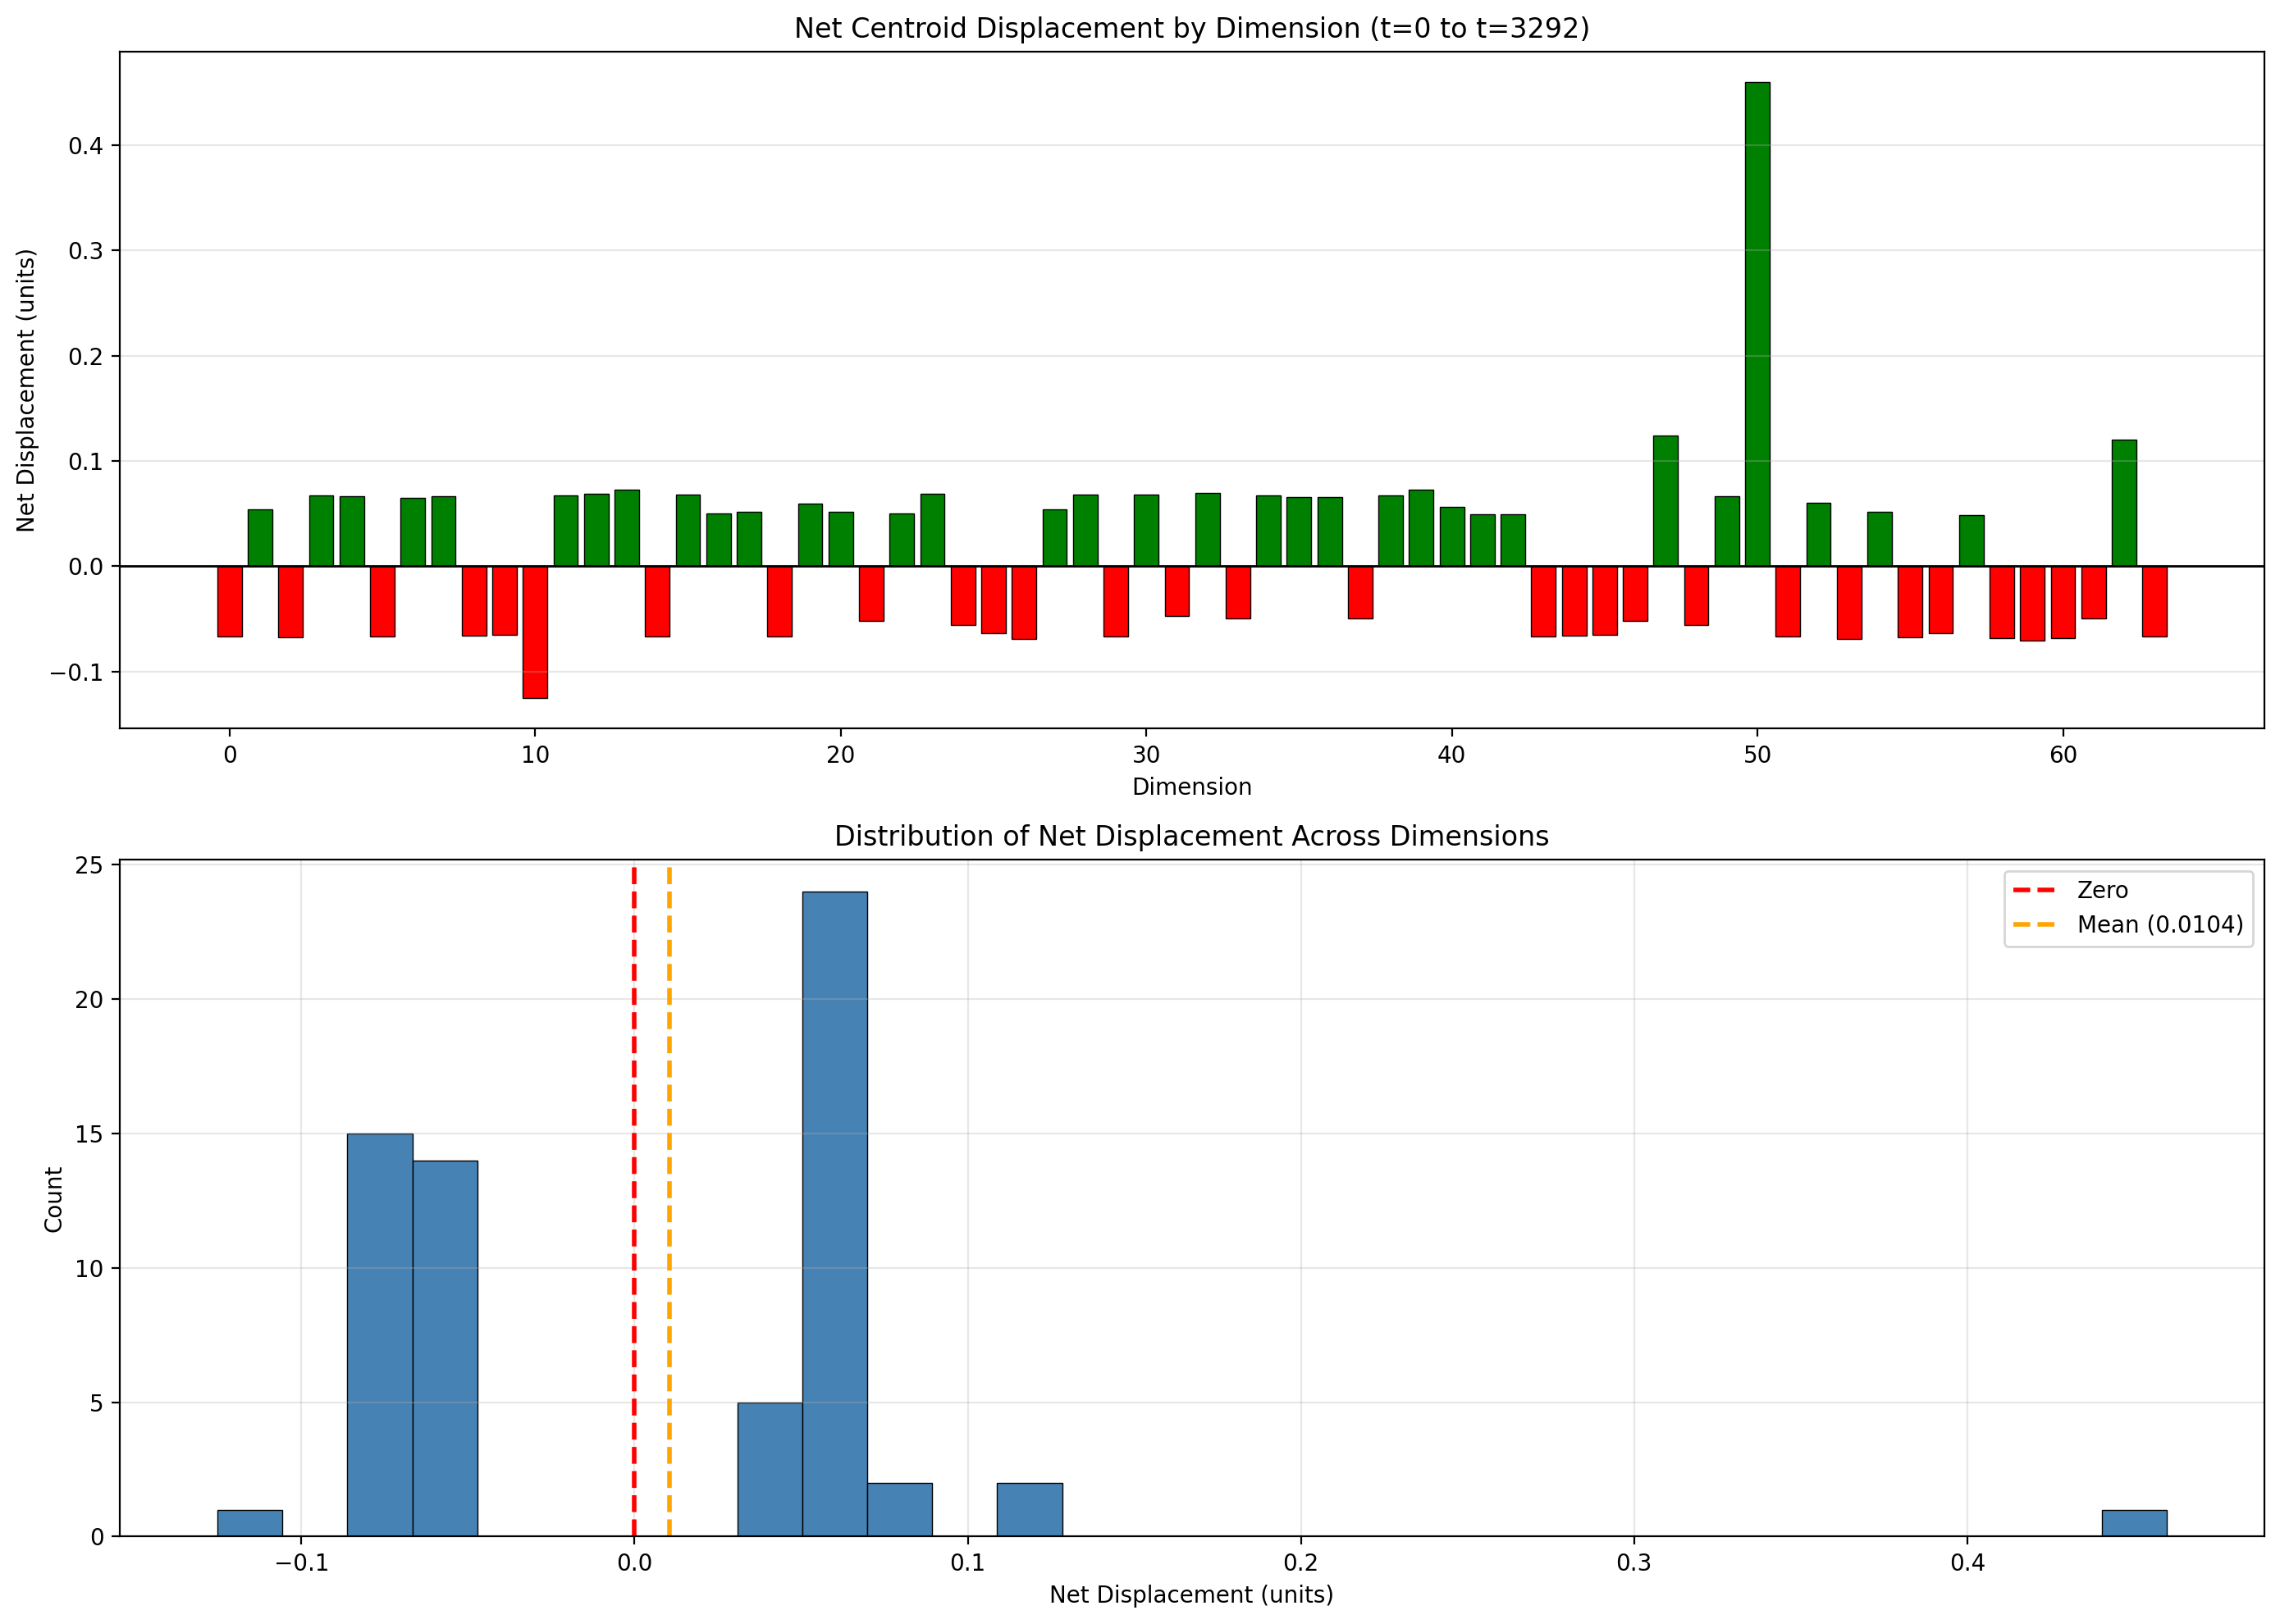


Interpretation:
  Symmetric around zero → no net directional bias
  Skewed positive → centroid drifts in +direction
  Skewed negative → centroid drifts in -direction


In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), dpi=200)

# Plot 1: Net displacement by dimension
ax = axes[0]
dims = np.arange(64)
net_disp_np = net_displacement.numpy()

colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in net_disp_np]
ax.bar(dims, net_disp_np, color=colors, edgecolor='black', linewidth=0.5)
ax.axhline(0, color='black', linewidth=1)

ax.set_xlabel('Dimension')
ax.set_ylabel('Net Displacement (units)')
ax.set_title(f'Net Centroid Displacement by Dimension (t=0 to t={ACTIVE_PERIOD_END})')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Histogram of net displacements
ax = axes[1]
ax.hist(net_disp_np, bins=30, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.axvline(net_disp_np.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean ({net_disp_np.mean():.4f})')

ax.set_xlabel('Net Displacement (units)')
ax.set_ylabel('Count')
ax.set_title('Distribution of Net Displacement Across Dimensions')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Symmetric around zero → no net directional bias")
print("  Skewed positive → centroid drifts in +direction")
print("  Skewed negative → centroid drifts in -direction")

## Statistical Test: Is This Random Walk Noise?

In [8]:
print("\n" + "=" * 80)
print("RANDOM WALK BASELINE")
print("=" * 80 + "\n")

# For unbiased random walk in D dimensions with N steps:
# Expected displacement: E[||R||] ≈ √(N × D) × step_size

D = 64
N = ACTIVE_PERIOD_END

# Typical step size (median centroid displacement per step)
step_sizes = torch.norm(centroid_displacement, dim=1)
typical_step = step_sizes.median().item()

# Expected displacement for unbiased random walk
expected_unbiased = typical_step * np.sqrt(N * D)

print(f"Dimensions: D = {D}")
print(f"Steps: N = {N}")
print(f"Typical step size (median): {typical_step:.6f} units\n")

print(f"Expected displacement (unbiased RW): {expected_unbiased:.6f} units")
print(f"Actual net displacement:             {net_magnitude:.6f} units\n")

ratio = net_magnitude / expected_unbiased if expected_unbiased > 0 else 0
print(f"Ratio (actual / expected): {ratio:.4f}")

if ratio > 1.5:
    print("  → Significantly larger than random walk (strong directional bias)")
elif ratio > 1.1:
    print("  → Slightly larger than random walk (weak directional bias)")
elif ratio > 0.9:
    print("  → Consistent with unbiased random walk")
else:
    print("  → Smaller than expected (unusual—cancellation?)")

print("\n" + "=" * 80)


RANDOM WALK BASELINE

Dimensions: D = 64
Steps: N = 3292
Typical step size (median): 0.000003 units

Expected displacement (unbiased RW): 0.001363 units
Actual net displacement:             0.701211 units

Ratio (actual / expected): 514.6259
  → Significantly larger than random walk (strong directional bias)



## Explanation: Can Bulk Drift Explain the 55/45 Split?

In [9]:
print("\n" + "=" * 80)
print("BULK DRIFT EXPLANATION FOR SIGN ASYMMETRY")
print("=" * 80 + "\n")

# If centroid drifts by d per step on average, and tokens have thermal jitter σ,
# then individual token displacements are: thermal + drift
# Sign ratio ≈ (0.5 + d/(2σ)) / (0.5 - d/(2σ))

# Mean centroid drift per step (scalar, considering sign)
mean_centroid_drift_per_dim = net_displacement.mean().item() / ACTIVE_PERIOD_END

# Typical thermal jitter (std of centroid displacements)
thermal_std = centroid_disp_flat.std().item()

# Predicted sign ratio from drift
if thermal_std > 0:
    drift_fraction = mean_centroid_drift_per_dim / thermal_std
    predicted_pos_frac = 0.5 + drift_fraction / 2
    predicted_neg_frac = 0.5 - drift_fraction / 2
    predicted_ratio = predicted_pos_frac / predicted_neg_frac if predicted_neg_frac > 0 else float('inf')
else:
    drift_fraction = 0
    predicted_ratio = 1.0

print("Observed (from 1.30i):")
print("-" * 80)
print("  Token displacements: 54.51% pos / 45.49% neg")
print("  Observed ratio: 1.198\n")

print("Model prediction (bulk drift + thermal jitter):")
print("-" * 80)
print(f"  Mean centroid drift per dim per step: {mean_centroid_drift_per_dim:+.6e} units")
print(f"  Thermal jitter std: {thermal_std:.6e} units")
print(f"  Drift/noise ratio: {drift_fraction:.6f}\n")

print(f"  Predicted sign distribution: {predicted_pos_frac:.2%} pos / {predicted_neg_frac:.2%} neg")
print(f"  Predicted ratio: {predicted_ratio:.3f}\n")

# Compare
actual_ratio = 1.198
error = abs(predicted_ratio - actual_ratio) / actual_ratio

print("Comparison:")
print("-" * 80)
print(f"  Predicted ratio: {predicted_ratio:.3f}")
print(f"  Observed ratio:  {actual_ratio:.3f}")
print(f"  Relative error:  {error:.2%}\n")

if error < 0.05:
    print("✓ Excellent agreement! Bulk drift explains the asymmetry.")
elif error < 0.15:
    print("✓ Good agreement. Bulk drift is likely the main cause.")
elif error < 0.30:
    print("~ Partial agreement. Bulk drift contributes but doesn't fully explain it.")
else:
    print("✗ Poor agreement. Bulk drift alone doesn't explain the asymmetry.")

print("\n" + "=" * 80)


BULK DRIFT EXPLANATION FOR SIGN ASYMMETRY

Observed (from 1.30i):
--------------------------------------------------------------------------------
  Token displacements: 54.51% pos / 45.49% neg
  Observed ratio: 1.198

Model prediction (bulk drift + thermal jitter):
--------------------------------------------------------------------------------
  Mean centroid drift per dim per step: +3.155600e-06 units
  Thermal jitter std: 1.174025e-04 units
  Drift/noise ratio: 0.026878

  Predicted sign distribution: 51.34% pos / 48.66% neg
  Predicted ratio: 1.055

Comparison:
--------------------------------------------------------------------------------
  Predicted ratio: 1.055
  Observed ratio:  1.198
  Relative error:  11.92%

✓ Good agreement. Bulk drift is likely the main cause.



## Final Summary

In [10]:
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80 + "\n")

print("Net centroid displacement:")
print(f"  Magnitude: {net_magnitude:.6f} units over {ACTIVE_PERIOD_END} steps")
print(f"  Dimension sign split: {n_pos_dims} pos / {n_neg_dims} neg (ratio {n_pos_dims/n_neg_dims:.3f})\n")

print("Step-by-step centroid displacement sign split:")
print(f"  {n_pos_steps/(n_pos_steps+n_neg_steps):.2%} pos / {n_neg_steps/(n_pos_steps+n_neg_steps):.2%} neg "
      f"(ratio {n_pos_steps/n_neg_steps:.3f})\n")

print("Token displacement sign split (from 1.30i):")
print(f"  54.51% pos / 45.49% neg (ratio 1.198)\n")

print("Conclusion:")
if abs(n_pos_steps/(n_pos_steps+n_neg_steps) - 0.5451) < 0.02:
    print("  ✓ Centroid drift closely matches token sign asymmetry.")
    print("  ✓ The 55/45 split is likely due to bulk motion of the dead token cloud.")
else:
    print("  ~ Centroid drift differs from token asymmetry.")
    print("  ~ Other factors may contribute to the sign distribution.")

print("\n" + "=" * 80)
print("✓ Centroid drift and sign bias analysis complete.")
print("=" * 80)


FINAL SUMMARY

Net centroid displacement:
  Magnitude: 0.701211 units over 3292 steps
  Dimension sign split: 34 pos / 30 neg (ratio 1.133)

Step-by-step centroid displacement sign split:
  56.99% pos / 43.01% neg (ratio 1.325)

Token displacement sign split (from 1.30i):
  54.51% pos / 45.49% neg (ratio 1.198)

Conclusion:
  ~ Centroid drift differs from token asymmetry.
  ~ Other factors may contribute to the sign distribution.

✓ Centroid drift and sign bias analysis complete.
